In [1]:
def normalize(df):
    result = df.copy()
    #for feature_name in df.columns:
    result = result.values
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

In [2]:
class style:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Data extraction

In [3]:
%load_ext autoreload
%autoreload 2
#plt.rcParams['figure.figsize'] = (16,8)

In [4]:
def run_dat_extract(path, country):
    
    ## Import data
    import pandas as pd
    from purchase_prediction.import_data import (import_transaction_club, 
                                                import_transaction_ecom, 
                                                import_sfid_email_ecom)

    #_set_params
#     path = 'u:\\Projects\\datasets\\customer_history\\spring_special_2020'
#     country = 'PL'

    # Import Club Customers
    df_club = import_transaction_club(country=country, 
                                      start_observation_period='01012018', 
                                      end_observation_period='01012020',
                                      path=path)
    # Import ECom NonClub Customers
    df_etmp = import_transaction_ecom(country=country, 
                                      start_observation_period='01012018', 
                                      end_observation_period='01012020',
                                      path=path)
    # Import keys linking mails and SFID
    df_keys = import_sfid_email_ecom('daily_segment_NL_data_JHL_20200220.csv')
    # Select these customers that have a valid email from ECom NonClub
    df_ecom = df_etmp.merge(df_keys, on= 'Email', how='inner')
    lost_cust = df_etmp.shape[0] - df_ecom.shape[0]
    print(str(lost_cust)+' lost ECom non Club customers based on Email merge')
    print('i.e., '+str((lost_cust / df_etmp.shape[0])*100)+'% lost ECom customers.')
    
    ## Munge data
    
    from purchase_prediction.munging_pipeline import (start_pipeline, 
                                                      select_valid_cards, 
                                                      correct_cols, 
                                                      def_types, 
                                                      down_sample,
                                                      correct_timestamps, 
                                                      correct_for_retourned,
                                                      drop_retours,
                                                      assign_customer_type,
                                                      rename_cols_ecom,
                                                      correct_timestamps_ecom,
                                                      def_types_ecom,
                                                      drop_cols
                                             )

    df_club_clean = (df_club
    .pipe(start_pipeline)
    .pipe(select_valid_cards)
    .pipe(correct_cols)            
    .pipe(correct_timestamps)
    .pipe(def_types,
          column_name='turnover_with_vat_euro',
          type=float)
    #.pipe(down_sample, threshold=50000)
    #.pipe(correct_for_retourned) # This steps is very long (should be optimized). Only use if monetary value required.
    .pipe(drop_retours)   
    .pipe(assign_customer_type,label='club')
    )

    print('')
    print('There are ' + str(df_club_clean.groupby(by='customer_salesforce_id').count().shape[0]) + ' club customers.')

    # df_club_clean.head(1)

    df_ecom_clean = (df_ecom
    .pipe(start_pipeline)
    .pipe(correct_cols)                  
    .pipe(rename_cols_ecom)
    .pipe(correct_timestamps_ecom)            
    .pipe(def_types_ecom)
    .pipe(drop_cols)   
    .pipe(assign_customer_type, label='ecom_nonclub')
    )

    print('There are ' + str(df_ecom_clean.groupby(by='eshop_id').count().shape[0]) + ' Ecom non club customers.')
    print('')

    # df_ecom_clean.head(1)

    from purchase_prediction.ml_pipeline import (select_recent_members, 
                                                 date_benchmarking, 
                                                 compute_age_recency, 
                                                 rename_cols, 
                                                 select_ml_data, 
                                             )

    from purchase_prediction.ml_pipeline_ecom import (select_receipt_dates_ecom, 
                                                      compute_age_recency_ecom, 
                                                      rename_cols_ecom_ml, 
                                                      add_frequency, 
                                                      select_ml_data_ecom, 
                                                 )
    now_time_reference = '2020-01-01T00'
    df_club_ml = (df_club_clean
    .pipe(start_pipeline)
#     .pipe(select_recent_members,
#     timestamp_bef='2018-01-01T00',
#     timestamp_aft=now_time_reference,
#     action = "between")
#    .pipe(date_benchmarking, upper_benchmark=now_time_reference)
    .pipe(compute_age_recency,timestamp_ref=now_time_reference)
    .pipe(rename_cols)
    .pipe(select_ml_data)
    )

    lost_customers = df_club_clean.groupby(by='club_card_number').count().shape[0] - df_club_ml.groupby(by='club_card_number').count().shape[0]
    print('Data cleansing yields ' + str(lost_customers) + ' lost customers.')
    print('#Customers select for ML pipeline = ' + str(df_club_ml.groupby(by='club_card_number').count().shape[0]))

    df_ecom_ml = (df_ecom_clean
    .pipe(select_receipt_dates_ecom, upper_benchmark=now_time_reference)
    .pipe(compute_age_recency_ecom,timestamp_ref=now_time_reference)
    .pipe(rename_cols_ecom_ml)
    .pipe(add_frequency)
    .pipe(select_ml_data_ecom)              
         )

    lost_customers = df_ecom_clean.groupby(by='sfid').count().shape[0] - df_ecom_ml.groupby(by='sfid').count().shape[0]
    print('Data cleansing yields ' + str(lost_customers) + ' lost customers.')
    print('#Customers select for Ecom ML pipeline = ' + str(df_ecom_ml.groupby(by='club_card_number').count().shape[0]))

    # POOLING CLUB & ECOM
    df_ml = (pd.concat([df_club_ml, df_ecom_ml], axis=0, join='outer', sort=False)
    .dropna() # Some customers have missing SFID
    )
    df_ml.head(5)
    return df_ml#, df_club_clean, df_club

## Model fit & test

In [5]:
def run_model(df_ml):
    # Import models
    from lifetimes import BetaGeoFitter,ParetoNBDFitter
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    #bgf_Pareto = ParetoNBDFitter(penalizer_coef=0.1)

    # Verify that the model is doing a relatively good job at predicting values
    from lifetimes.utils import calibration_and_holdout_data
    # This function creates a summary of each customer over a calibration and holdout period (training and testing)
    # It accepts transaction data, and returns a DataFrame of sufficient statistics.
    summary_cal_holdout = calibration_and_holdout_data(df_ml, 'sfid', 'receipt_issue_date',
                                                        calibration_period_end='2018-10-01',
                                                        observation_period_end='2019-10-01',
                                                        freq='W',
                                                        monetary_value_col = 'monetary_value')

    from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

    bgf.fit(summary_cal_holdout['frequency_cal'], 
            summary_cal_holdout['recency_cal'], 
            summary_cal_holdout['T_cal'])
    plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

    # Model summary
#     print('Model Summary')
#     print(bgf.summary)

    ## Model fit over all data to predict 2020

    # Transform transaction data into customer-based data with three attributes
    from lifetimes.utils import summary_data_from_transaction_data

    summary = summary_data_from_transaction_data(df_ml, 
                                                 'sfid', 
                                                 'receipt_issue_date', 
                                                 observation_period_end='2019-10-01',
                                                 datetime_format = '%Y-%m-%d',
                                                 freq='W',
                                                 monetary_value_col = 'monetary_value')
#     print('Sample of ML data')
#     print(summary.sample(2))
    print('')

    from lifetimes import BetaGeoFitter

    # similar API to scikit-learn and lifelines.
    # I am using some penalizer due to low sample size, see lifetimes documentation.
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(summary['frequency'], summary['recency'], summary['T'])
    print(bgf.summary)

    # Add predicted purchases to summary dataframe
    # Predicted purchases are calculated for a given time window t
    t = 4
    summary['pred_purch_coming_week=' + str(t)] = (bgf.conditional_expected_number_of_purchases_up_to_time
                                                   (
                                                    t, 
                                                    summary['frequency'], 
                                                    summary['recency'], 
                                                    summary['T']
                                                   )
                                                  )

    from lifetimes.plotting import plot_period_transactions
    plot_period_transactions(bgf)
    return summary

## Run the good stuff

In [11]:
summary = pd.DataFrame()
countries = ['DE', 'SI', 'SK', 'RS', 'AT', 'PL', 'CZ', 'HU', 'HR', 'RO']

Now calculating prediction for DE


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


538709 lost ECom non Club customers based on Email merge
i.e., 78.5865166637977% lost ECom customers.
f/ select_valid_cards cleaned: 3568337 (i.e., 22.51% of initial data) entries from input dataf.

There are 2621687 club customers.
There are 79051 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 2714742
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 79051


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.565968  0.000832         0.564337         0.567599
alpha  14.267675  0.026955        14.214842        14.320507
a       0.064688  0.000551         0.063608         0.065767
b       0.790596  0.007154         0.776575         0.804617


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Now calculating prediction for SI


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


5372 lost ECom non Club customers based on Email merge
i.e., 49.48415622697126% lost ECom customers.
f/ select_valid_cards cleaned: 79468 (i.e., 10.82% of initial data) entries from input dataf.

There are 130651 club customers.
There are 4711 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 135765
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 4711


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.926174  0.006078         0.914260         0.938088
alpha  18.602648  0.142244        18.323849        18.881447
a       0.013294  0.001140         0.011060         0.015527
b       0.458106  0.036762         0.386053         0.530159
Now calculating prediction for SK


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


40609 lost ECom non Club customers based on Email merge
i.e., 67.3773456554562% lost ECom customers.
f/ select_valid_cards cleaned: 451698 (i.e., 23.1% of initial data) entries from input dataf.

There are 272298 club customers.
There are 12027 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 286835
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 12027


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.831163  0.003532         0.824239         0.838086
alpha  15.704184  0.079337        15.548684        15.859683
a       0.023300  0.000946         0.021446         0.025153
b       0.631657  0.024797         0.583055         0.680258
Now calculating prediction for RS
269 lost ECom non Club customers based on Email merge
i.e., 44.46280991735537% lost ECom customers.
f/ select_valid_cards cleaned: 62438 (i.e., 10.3% of initial data) entries from input dataf.

There are 125194 club customers.
There are 302 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 129030
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 302


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.708832  0.004905         0.699218         0.718446
alpha  15.649308  0.136837        15.381107        15.917509
a       0.083566  0.002980         0.077725         0.089406
b       0.861859  0.033017         0.797146         0.926572


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Now calculating prediction for AT


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


51490 lost ECom non Club customers based on Email merge
i.e., 75.17995590532787% lost ECom customers.
f/ select_valid_cards cleaned: 595998 (i.e., 15.78% of initial data) entries from input dataf.

There are 660720 club customers.
There are 10229 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 682198
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 10229


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.631683  0.001791         0.628171         0.635194
alpha  15.193498  0.053744        15.088160        15.298835
a       0.038512  0.000819         0.036908         0.040117
b       0.708599  0.015172         0.678862         0.738337
Now calculating prediction for PL


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


307378 lost ECom non Club customers based on Email merge
i.e., 82.20025779674705% lost ECom customers.
f/ select_valid_cards cleaned: 1128949 (i.e., 9.01% of initial data) entries from input dataf.

There are 2185507 club customers.
There are 39746 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 2270804
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 39746


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.617691  0.000935         0.615860         0.619523
alpha  14.114017  0.026938        14.061219        14.166815
a       0.054432  0.000509         0.053435         0.055430
b       0.823597  0.008141         0.807641         0.839554


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Now calculating prediction for CZ


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


84215 lost ECom non Club customers based on Email merge
i.e., 73.54764899042829% lost ECom customers.
f/ select_valid_cards cleaned: 598291 (i.e., 13.24% of initial data) entries from input dataf.

There are 744331 club customers.
There are 17408 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 785579
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 17408


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.789261  0.002020         0.785302         0.793219
alpha  16.946445  0.052319        16.843900        17.048991
a       0.041816  0.000769         0.040309         0.043324
b       0.829737  0.015003         0.800331         0.859143


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Now calculating prediction for CH


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


2 lost ECom non Club customers based on Email merge
i.e., 50.0% lost ECom customers.
f/ select_valid_cards cleaned: 172888 (i.e., 33.25% of initial data) entries from input dataf.

There are 96866 club customers.
There are 2 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 101565
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 2


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.527349  0.004075         0.519362         0.535337
alpha  15.044969  0.151434        14.748160        15.341779
a       0.094656  0.003701         0.087403         0.101909
b       0.900892  0.036972         0.828427         0.973358


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Now calculating prediction for HU


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


89191 lost ECom non Club customers based on Email merge
i.e., 64.77855410136107% lost ECom customers.
f/ select_valid_cards cleaned: 846909 (i.e., 21.36% of initial data) entries from input dataf.

There are 398158 club customers.
There are 27246 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 428131
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 27246


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.886247  0.002832         0.880695         0.891798
alpha  11.903492  0.045586        11.814144        11.992841
a       0.044030  0.000804         0.042453         0.045606
b       0.978068  0.019522         0.939805         1.016332
Now calculating prediction for HR


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


5420 lost ECom non Club customers based on Email merge
i.e., 51.46709714177191% lost ECom customers.
f/ select_valid_cards cleaned: 124847 (i.e., 15.71% of initial data) entries from input dataf.

There are 145456 club customers.
There are 4089 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 151599
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 4089


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.691971  0.004323         0.683499         0.700444
alpha  15.168728  0.119321        14.934858        15.402597
a       0.060146  0.002173         0.055886         0.064405
b       0.726255  0.028766         0.669874         0.782636
Now calculating prediction for RO


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


56717 lost ECom non Club customers based on Email merge
i.e., 62.78379844360561% lost ECom customers.
f/ select_valid_cards cleaned: 977008 (i.e., 35.66% of initial data) entries from input dataf.

There are 390761 club customers.
There are 20666 Ecom non club customers.

Data cleansing yields 0 lost customers.
#Customers select for ML pipeline = 412567
Data cleansing yields 0 lost customers.
#Customers select for Ecom ML pipeline = 20666


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)



            coef  se(coef)  lower 95% bound  upper 95% bound
r       0.656120  0.002504         0.651212         0.661029
alpha  13.264879  0.064271        13.138908        13.390851
a       0.079579  0.001521         0.076598         0.082561
b       0.913032  0.018884         0.876018         0.950045


C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


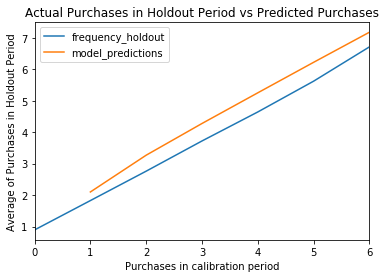

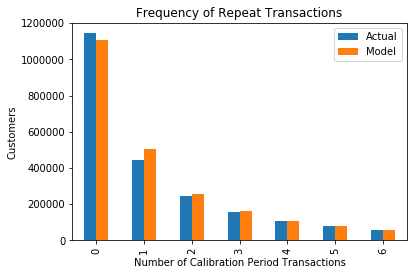

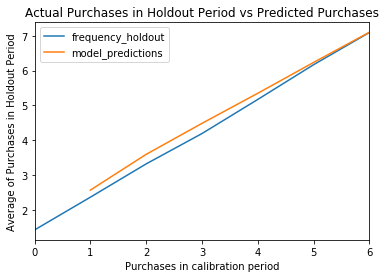

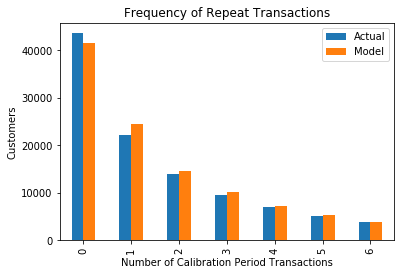

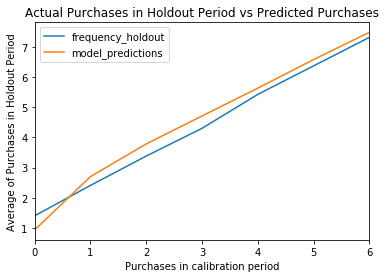

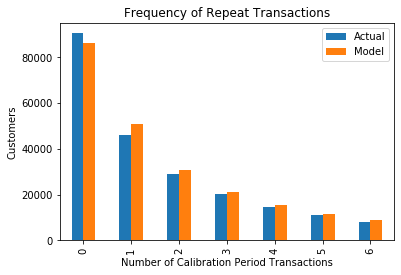

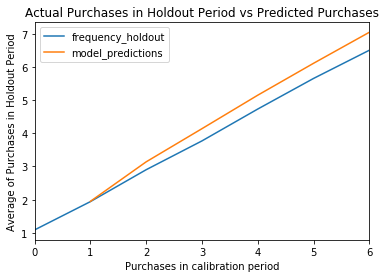

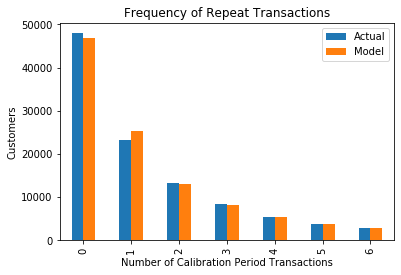

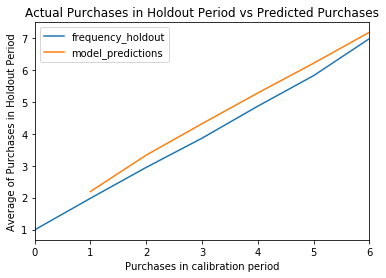

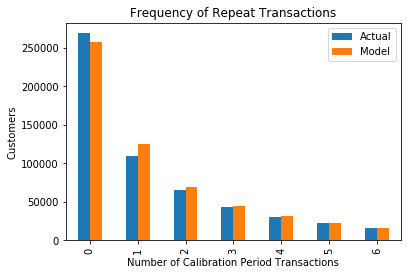

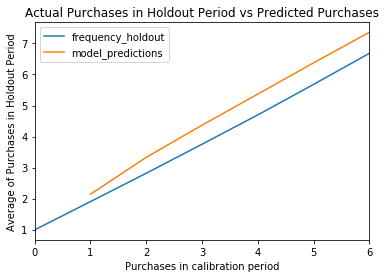

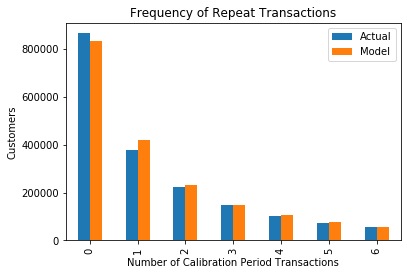

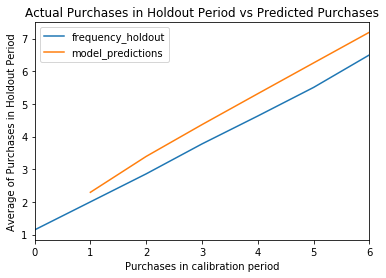

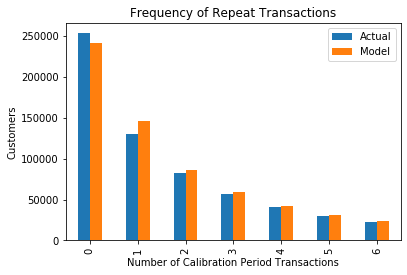

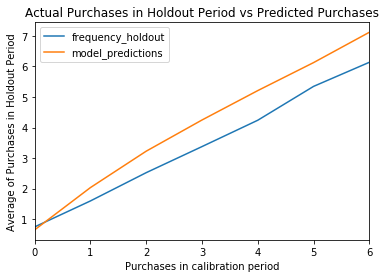

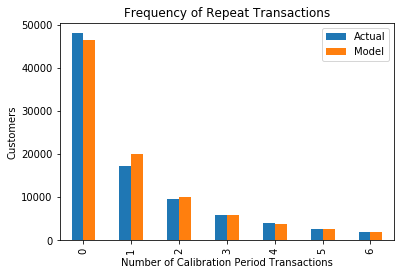

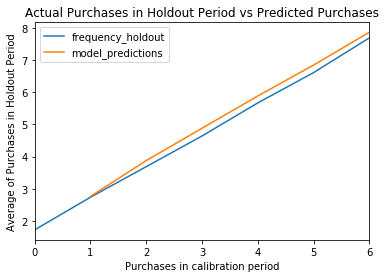

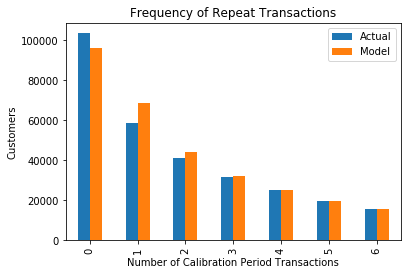

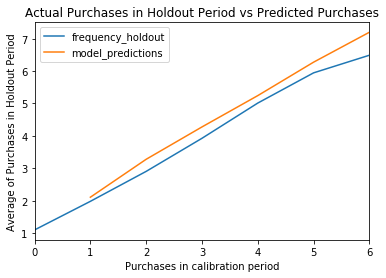

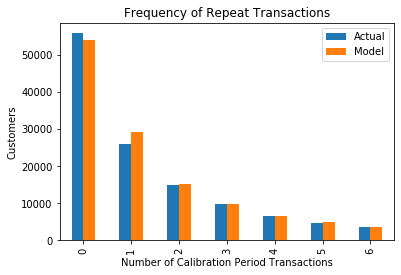

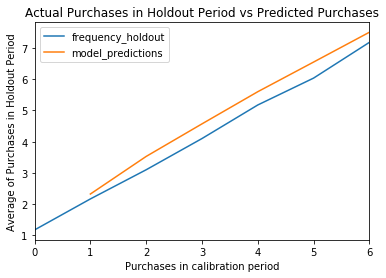

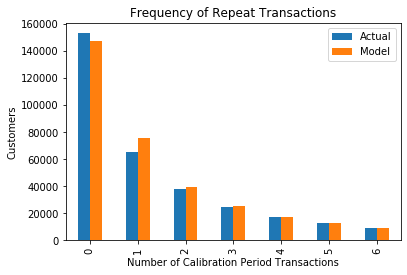

In [9]:
for i in countries:
    #_set_params
    #path = 'u:\\Projects\\datasets\\customer_history\\spring_special_2020'
    path = 'u:\\Projects\\datasets\\customer_history\\winter_celebration'
    country = i
    print(style.BOLD + style.BLUE + 'Now calculating prediction for ' + country + style.END)
    # extract data
    df_ml = run_dat_extract(path=path, country=country)

    # run model
    to_append = run_model(df_ml=df_ml)

    to_append = to_append.assign(norm_purchase = normalize(to_append['pred_purch_coming_week=4'])).reset_index()
    summary = summary.append(to_append)

In [12]:
summary.to_csv('PRED_PURCHASE_ALL_COUNTRIES.csv')

In [14]:
summary = pd.read_csv('PRED_PURCHASE_ALL_COUNTRIES.csv')

## Comparison DeFacto

In [40]:
import os
import plotnine as p9
import pandas as pd

def normalize(df):
    result = df.copy()
    #for feature_name in df.columns:
    result = result.values
    max_value = df.max()
    min_value = df.min()
    result = (df - min_value) / (max_value - min_value)
    return result

path = 'u:\\Projects\\datasets\\customer_history\\DeFacto_scores'
os.chdir(path)
file = 'Orsay_Promo_salesforce_January_2020.csv' # PreSale January 2020
#file = '20190913_Score_Winter_Celebration.csv'   # Winter Celebration October 2019
#file = '20191025_Winter_Presale_Daten_Score.csv' # Winter PreSale November 2019
os.chdir(path)
os.getcwd()

## Import data
files = os.listdir()
df_defacto = pd.read_csv(files[files.index(file)],sep=';', 
                          header = 0,
                          decimal=",",
                          #encoding='Latin-1'
                        )
df_defacto.columns = [c.lower() for c in df_defacto.columns]

df_orsay = summary.copy()
df_orsay = df_orsay.assign(norm_purchase = lambda d: normalize(d['pred_purch_coming_week=4']))
df_orsay.reset_index(level=0, inplace=True)

In [46]:
# merged_orsay_defacto_data = df_orsay.merge(df_defacto, on='sfid', how='inner')
#df_defacto.kunde_id = df_defacto.kunde_id.astype('str')
merged_orsay_defacto_data = df_orsay.merge(df_defacto, on='sfid', how='inner')
print('We loose ' + str(df_orsay.shape[0] - merged_orsay_defacto_data.shape[0]) + ' customers with DeFacto merging')



print('Correlation coefficients between DeFacto and Orsay scoring:')
print(merged_orsay_defacto_data.corr()['score'])

MemoryError: Unable to allocate array with shape (2, 8880169) and data type object

In [32]:
df_defacto

,kunde_id,kunde_konto_kz_ref_land,kunde_dim_abc,score
0,40289583,RO,4,0.039480
1,40291148,RO,4,0.033108
2,40291800,PL,4,0.039685
3,40291126,DE,4,0.030001
4,40291420,PL,4,0.035346
...,...,...,...,...
7748925,32596219,DE,4,0.030092
7748926,32597359,CZ,3,0.059771
7748927,32603095,PL,4,0.072415
7748928,32834129,PL,3,0.084508


In [ ]:
(p9.ggplot(mapping=p9.aes(x='norm_purchase', y='score'), data=merged_orsay_defacto_data)
+ p9.geom_point( alpha=0.1))

C:\Users\jhernandez-lallement\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:452: PlotnineWarning: geom_point : Removed 13999 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


In [225]:
# Look for divergent customers
(merged_orsay_defacto_data.loc[(merged_orsay_defacto_data.norm_purchase < 0.1) & (merged_orsay_defacto_data.score > 0.5)]
.sort_values(by='norm_purchase', ascending=True)
)

,sfid,frequency,recency,T,monetary_value,pred_purch_coming_week=4,norm_purchase,scoringidentifier,score
1612457,0035800000h7Df2AAE,48.0,59.0,91.0,62.116667,0.000031,0.000009,Spring Special 2020,0.592438
1672744,0035800000lSq87AAC,24.0,39.0,85.0,132.846667,0.000083,0.000024,Spring Special 2020,0.611608
1634443,0035800000iBTtBAAW,53.0,62.0,90.0,75.367925,0.000089,0.000026,Spring Special 2020,0.979622
1665312,0035800000kqHhpAAE,42.0,60.0,91.0,118.965000,0.000371,0.000107,Spring Special 2020,0.767284
2221704,0035800001VOn0XAAT,20.0,32.0,70.0,208.754500,0.001315,0.000379,Spring Special 2020,0.507836
...,...,...,...,...,...,...,...,...,...
2204235,0035800001UHKnbAAH,7.0,72.0,72.0,134.661429,0.346945,0.099908,Spring Special 2020,0.732246
1772246,0035800000xgJGVAA2,7.0,72.0,72.0,129.675714,0.346945,0.099908,Spring Special 2020,0.642193
1243630,0035800000HVRCTAA5,7.0,72.0,72.0,89.147993,0.346945,0.099908,Spring Special 2020,0.656836
717284,0035800000Ge3hpAAB,8.0,71.0,82.0,166.848750,0.347262,0.100000,Spring Special 2020,0.507302


# CLV

In [35]:
returning_customers_summary = summary.copy()
returning_customers_summary = returning_customers_summary[returning_customers_summary['monetary_value']>0]
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.122942
frequency,0.122942,1.000000


In [36]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.001)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1314789 subjects, p: 5.85, q: 1.69, v: 6.93>


In [122]:
clv = ggf.conditional_expected_average_profit(returning_customers_summary['frequency'],
                                              returning_customers_summary['monetary_value']
                  
                                             )

In [38]:
from lifetimes import BetaGeoFitter,ParetoNBDFitter
bgf = BetaGeoFitter(penalizer_coef=0.001)
# refit the BG model to the summary_with_money_value dataset
bgf.fit(returning_customers_summary['frequency'], 
        returning_customers_summary['recency'], 
        returning_customers_summary['T'],
        returning_customers_summary['monetary_value'])

clv_dcf = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    returning_customers_summary['frequency'],
    returning_customers_summary['recency'],
    returning_customers_summary['T'],
    returning_customers_summary['monetary_value'],
    time=1, # months
    discount_rate=0.01,# monthly discount rate ~ 12.7% annually
    freq = 'W')

In [185]:
clv_to_merge = pd.DataFrame(clv).merge(clv_dcf,on='sfid', how='left').reset_index().rename(columns={'clv': 'clv_dcf',
                                                                                                    0: 'clv'})
clv_to_merge = (clv_to_merge
.assign(clv = lambda d: d['clv'].fillna(value=0))
.assign(clv_dcf = lambda d: d['clv_dcf'].fillna(value=0))
.assign(norm_clv = lambda d: normalize(d['clv']))
.assign(norm_clv_dcf = lambda d: normalize(d['clv_dcf']))
)

In [186]:
merged_final_data = pd.merge(merged_orsay_defacto_data, clv_to_merge, on= 'sfid', how= 'left')

In [216]:
merged_final_data = merged_final_data.assign(overall_score = lambda d: normalize(d.clv * d.norm_purchase))

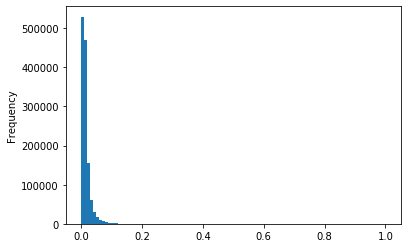

In [221]:
merged_final_data.norm_clv.plot(kind='hist', bins=100)

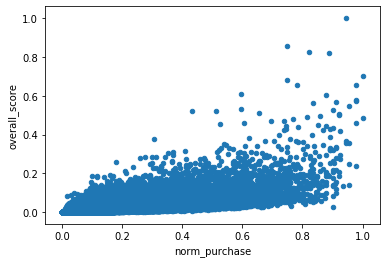

In [218]:
merged_final_data.plot(kind='scatter', x='norm_purchase', y='overall_score')

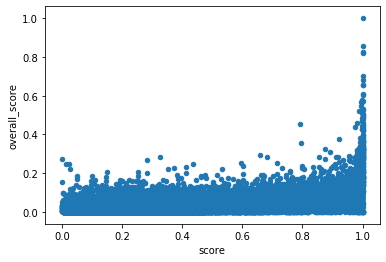

In [219]:
merged_final_data.plot(kind='scatter', x='score', y='overall_score')

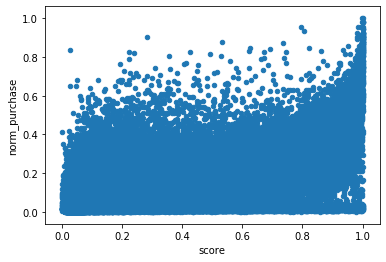

In [215]:
merged_final_data.plot(kind='scatter', x='score', y='norm_purchase')

In [195]:
merged_final_data.columns

Index(['sfid', 'frequency', 'recency', 'T', 'monetary_value',
       'pred_purch_coming_week=4', 'norm_purchase', 'scoringidentifier',
       'score', 'clv', 'clv_dcf', 'norm_clv', 'norm_clv_dcf', 'overall_score'],
      dtype='object')

In [110]:
merged_final_data[['clv', 
                   'clv_dcf', 
                   'norm_clv',
                   'norm_clv_dcf',
                   'overall_score',
                   'overall_score_norm']] = (merged_final_data[['clv', 
                                                               'clv_dcf', 
                                                               'norm_clv', 
                                                               'norm_clv_dcf',
                                                                'overall_score',
                                                                ]]
.fillna(value = 0)
)

In [5]:
merged_final_data.loc[(merged_final_data.norm_purchase < 0.1) & (merged_final_data.clv > 0.1)].mean()

NameError: name 'merged_final_data' is not defined